## 1. Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import os

## 2. Paths & Columns

In [2]:
RAW_TRAIN_PATH = "../data/raw/KDDTrain+.txt"
RAW_TEST_PATH = "../data/raw/KDDTest+.txt"
PROCESSED_DIR = "../data/processed/"

columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label"
]

## 3. Load Dataset

In [3]:
train_df = pd.read_csv(RAW_TRAIN_PATH, header=None, names=columns)
test_df = pd.read_csv(RAW_TEST_PATH, header=None, names=columns)

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (125973, 42)
Test set shape: (22544, 42)


## 4. Data Cleaning

### 4.1 Missing values check

In [4]:
print("\n[INFO] Missing values in Training Data:")
print(train_df.isnull().sum())
print("\n[INFO] Missing values in Test Data:")
print(test_df.isnull().sum())

# If missing values exist, fill them (here we just fill numeric with median and categorical with mode)
for df in [train_df, test_df]:
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)


[INFO] Missing values in Training Data:
duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
di

### 4.2 Remove duplicates

In [5]:
initial_train_shape = train_df.shape
initial_test_shape = test_df.shape

train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

print(f"[INFO] Removed {initial_train_shape[0] - train_df.shape[0]} duplicate rows from training data")
print(f"[INFO] Removed {initial_test_shape[0] - test_df.shape[0]} duplicate rows from test data")

[INFO] Removed 1255 duplicate rows from training data
[INFO] Removed 128 duplicate rows from test data


### 4.3 Outliers

In [6]:
# We KEEP outliers because in IDS, rare/abnormal values may represent attacks.
print("[INFO] Outliers are kept for anomaly detection.")

[INFO] Outliers are kept for anomaly detection.


## 5. Encode Categorical Features

In [11]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["protocol_type", "service", "flag", "label"]

# Encode train and test together to avoid unseen category errors
for col in categorical_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]])  # stack train + test
    le.fit(combined)  # fit on all unique categories
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    print(f"[INFO] Encoded column '{col}' with {len(le.classes_)} unique classes.")

[INFO] Encoded column 'protocol_type' with 70 unique classes.
[INFO] Encoded column 'service' with 11 unique classes.
[INFO] Encoded column 'flag' with 3611 unique classes.
[INFO] Encoded column 'label' with 22 unique classes.


## 6. Scale Numerical Features

In [13]:
print(train_df.dtypes)
print(test_df.dtypes)

duration                        object
protocol_type                    int64
service                          int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                      float64
serror_rate                    float64
srv_serror_rate          

In [14]:
# Convert object columns to numeric (forcing non-numeric to NaN)
train_df["duration"] = pd.to_numeric(train_df["duration"], errors="coerce")
test_df["duration"] = pd.to_numeric(test_df["duration"], errors="coerce")

train_df["dst_host_srv_rerror_rate"] = pd.to_numeric(train_df["dst_host_srv_rerror_rate"], errors="coerce")
test_df["dst_host_srv_rerror_rate"] = pd.to_numeric(test_df["dst_host_srv_rerror_rate"], errors="coerce")

# Fill NaNs that may have appeared after coercion
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature_cols = train_df.columns[:-1]  # All except label

train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("[INFO] Scaling complete.")

[INFO] Scaling complete.


## 7. Check Class Imbalance

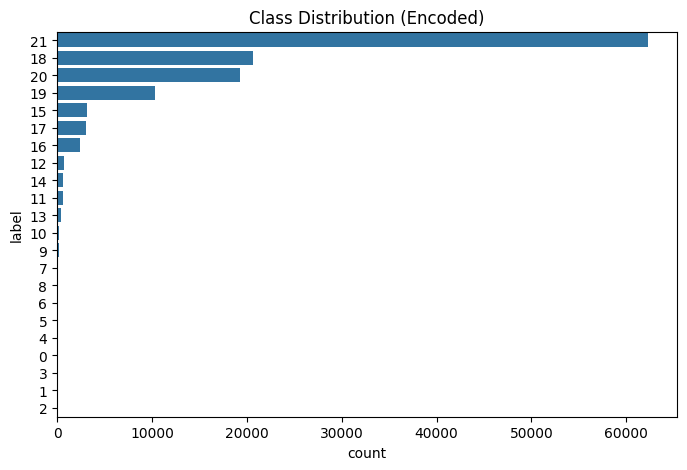

Class counts: Counter({21: 62238, 18: 20628, 20: 19315, 19: 10283, 15: 3150, 17: 3073, 16: 2373, 12: 729, 14: 671, 11: 641, 13: 450, 10: 253, 9: 191, 7: 117, 8: 106, 6: 96, 5: 81, 4: 79, 0: 66, 3: 65, 1: 61, 2: 52})


In [16]:
plt.figure(figsize=(8,5))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title("Class Distribution (Encoded)")
plt.show()

print("Class counts:", Counter(train_df['label']))

## 8. Apply SMOTE (Optional)

[INFO] Class distribution before SMOTE: Counter({20: 62238, 15: 62238, 19: 62238, 21: 62238, 18: 62238, 17: 62238, 16: 62238, 12: 62238, 14: 62238, 11: 62238, 2: 62238, 13: 62238, 10: 62238, 9: 62238, 8: 62238, 7: 62238, 3: 62238, 5: 62238, 1: 62238, 6: 62238, 0: 62238, 4: 62238})
[INFO] Class distribution after SMOTE: Counter({20: 62238, 15: 62238, 19: 62238, 21: 62238, 18: 62238, 17: 62238, 16: 62238, 12: 62238, 14: 62238, 11: 62238, 2: 62238, 13: 62238, 10: 62238, 9: 62238, 8: 62238, 7: 62238, 3: 62238, 5: 62238, 1: 62238, 6: 62238, 0: 62238, 4: 62238})


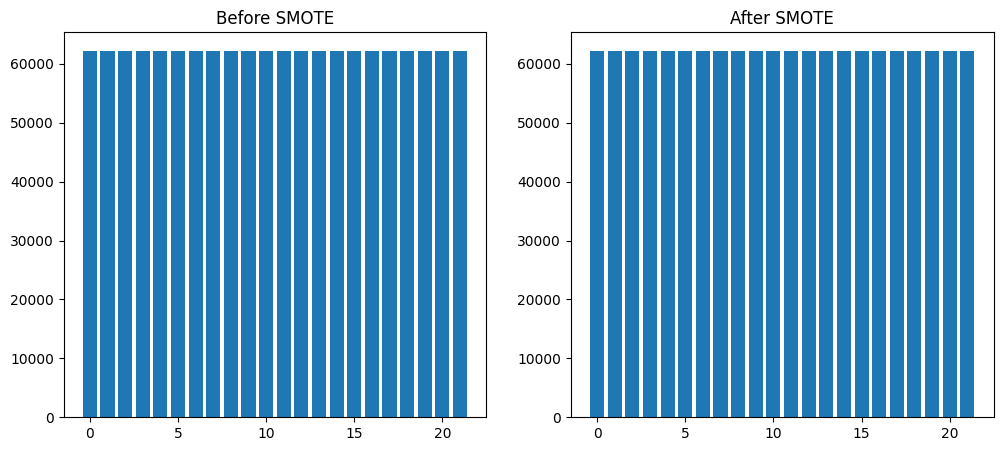

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

apply_smote = True  # Set False if you want to skip balancing

if apply_smote:
    X_train = train_df.drop("label", axis=1)
    y_train = train_df["label"]

    print("[INFO] Class distribution before SMOTE:", Counter(y_train))

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    # Replace train_df with balanced version
    train_df = pd.concat([pd.DataFrame(X_res, columns=X_train.columns), 
                          pd.Series(y_res, name="label")], axis=1)

    print("[INFO] Class distribution after SMOTE:", Counter(train_df["label"]))

    # Optional: Plot before/after distribution
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].bar(Counter(y_train).keys(), Counter(y_train).values())
    axes[0].set_title("Before SMOTE")
    axes[1].bar(Counter(y_res).keys(), Counter(y_res).values())
    axes[1].set_title("After SMOTE")
    plt.show()
else:
    print("[INFO] SMOTE skipped.")

## 9. Save Processed Data

In [20]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

train_df.to_csv(f"{PROCESSED_DIR}/train_processed.csv", index=False)
test_df.to_csv(f"{PROCESSED_DIR}/test_processed.csv", index=False)

print(f"[INFO] Processed files saved in {PROCESSED_DIR}")

[INFO] Processed files saved in ../data/processed/
